# Урок 4. Домашнее задание

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [168]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=800, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

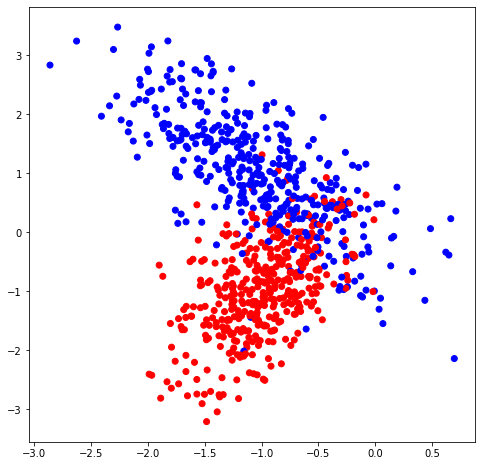

In [169]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

###  Добавим класс арбитр, на осонвании изменения свойств  экземпляра класса будем принимать решение о остановке рекурсии

In [170]:
class Arbitrator:

    def __init__(self, nodes_n, leaf_n, deep_tree):
        self.nodes_n = nodes_n
        self.leaf_n = leaf_n
        self.deep_tree = deep_tree
        self.leaf_know = 0  # используется для проверки кол-ва листьев, для работы основной рекурсии не требуется
        self.node_know = 0  # аналогично, узлы, впрочем кол-во узлов равно leaf_n - 1
        self.deep_know = 0  # аналогично, глубина  

In [171]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [172]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [173]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [174]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [175]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [176]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [177]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels,  cur_level, node =0, leaf = 0, deep = 0):
        flag = False
        print(ar.nodes_n, ar.leaf_n, ar.deep_tree)
        # print(ar.leaf_n)
        if deep != 0:
            if cur_level > deep:
                ar.leaf_n = ar.leaf_n + 1
                return Leaf(data, labels)
            else:
                flag = True
        elif leaf != 0:
            if ar.leaf_n > leaf:
                ar.leaf_n = ar.leaf_n + 1
                return Leaf(data, labels)
            else:
                flag = True
        elif node != 0:
            if ar.nodes_n > node:
                ar.leaf_n = ar.leaf_n + 1
                return Leaf(data, labels)
            else:
                flag = True
        else: flag = True
        if flag:
            #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
            quality, t, index = find_best_split(data, labels)
            if quality == 0:
                ar.leaf_n = ar.leaf_n + 1
                return Leaf(data, labels)
            else:
                ar.nodes_n = ar.nodes_n + 1
                true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
                # Рекурсивно строим два поддерева
                level = cur_level + 1
                ar.deep_tree = max(level, ar.deep_tree)
                true_branch = build_tree(true_data, true_labels, cur_level=level, node=node, leaf=leaf, deep=deep)
                false_branch = build_tree(false_data, false_labels, cur_level=level, node=node, leaf=leaf, deep=deep)

                # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
                return Node(index, t, true_branch, false_branch)

In [178]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [179]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [180]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [181]:
test_labels

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

In [200]:
# Построим дерево по обучающей выборке
ar = Arbitrator(0,0,0)
my_tree = build_tree(train_data, train_labels, cur_level = 0, deep = 3)
print(ar.nodes_n, ar.leaf_n, ar.deep_tree)

0 0 0
1 0 1
2 0 2
3 0 3
4 0 4
4 1 4
4 2 4
5 2 4
5 3 4
5 4 4
6 4 4
7 4 4
7 5 4
7 6 4
7 7 4
8 7 4
9 7 4
10 7 4
10 8 4
10 9 4
11 9 4
11 10 4
11 11 4
12 11 4
13 11 4
13 12 4
13 13 4
14 13 4
14 14 4
14 15 4


In [201]:
def print_ar(ar, spacing):
    # Печатаем арбитра
    print(f'{spacing}N={ar.node_know} L={ar.leaf_know}  D={ar.deep_know}')

In [202]:
# Напечатаем ход нашего дерева
def print_tree(node, n, spacing=""):
    print_ar(ar, spacing)
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        ar.leaf_know = ar.leaf_know +1
        return
    if isinstance(node, Node):
        ar.node_know = ar.node_know +1

    deep = n+1

    # Выведем значение индекса и порога на этом узле
    ar.deep_know = deep
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch,deep, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch,deep,  spacing + "  ")

    
print_tree(my_tree, 0)

N=0 L=0  D=0
Индекс 1
Порог 0.13487041249253684
--> True:
  N=1 L=0  D=1
  Индекс 0
  Порог -0.4658201109093335
  --> True:
    N=2 L=0  D=2
    Индекс 1
    Порог -0.40663390905814234
    --> True:
      N=3 L=0  D=3
      Индекс 0
      Порог -0.6366685274725341
      --> True:
        N=4 L=0  D=4
        Прогноз: 0
      --> False:
        N=4 L=1  D=4
        Прогноз: 0
    --> False:
      N=4 L=2  D=4
      Индекс 0
      Порог -0.5249627609775233
      --> True:
        N=5 L=2  D=4
        Прогноз: 0
      --> False:
        N=5 L=3  D=4
        Прогноз: 1
  --> False:
    N=5 L=4  D=4
    Индекс 0
    Порог -0.18029850901586197
    --> True:
      N=6 L=4  D=3
      Индекс 0
      Порог -0.2749856869969164
      --> True:
        N=7 L=4  D=4
        Прогноз: 1
      --> False:
        N=7 L=5  D=4
        Прогноз: 0
    --> False:
      N=7 L=6  D=4
      Прогноз: 1
--> False:
  N=7 L=7  D=4
  Индекс 0
  Порог -0.5862310572574423
  --> True:
    N=8 L=7  D=2
    Индекс 0
   

In [203]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [204]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [205]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [206]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.67857142857143

In [207]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

90.83333333333333

Text(0.5, 1.0, 'Test accuracy=90.83')

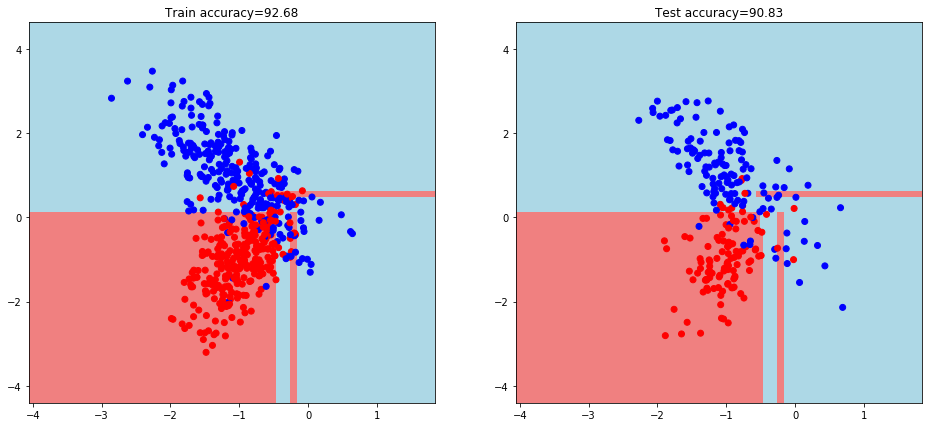

In [208]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')